# Gold EDA

This notebook conducts EDA aimed at generating a gold layer of data, which is considered ready for model consumption. EDA in this notebook will analyze the various predictor variables in the context of the "binds" target variable. It will also analyze some options for converting the "molecule_smiles" string representation of a molecule into a numeric representation that can be better consumed by a model. 

Recall this project uses a psuedo [medallion](https://www.databricks.com/glossary/medallion-architecture) where the gold layer is model ready data. 

In [1]:
import sys
import polars as pl
import matplotlib.pyplot as plt

sys.path.append('..')
from leash_bio_ai.utils.conf import silver_train_dir

In [2]:
silver_df = pl.read_parquet(source=silver_train_dir)
silver_df.head()

id,molecule_smiles,protein_int,binds
i64,str,i8,i8
466,"""C#CCOc1ccc(CNc2nc(NCc3ccc4[nH]…",1,1
467,"""C#CCOc1ccc(CNc2nc(NCc3ccc4[nH]…",2,1
683,"""C#CCOc1ccc(CNc2nc(NCC34CC5CC(C…",2,1
1321,"""C#CCOc1ccc(CNc2nc(Nc3n[nH]c4nc…",1,1
2141,"""C#CCOc1cccc(CNc2nc(NCc3ccc4[nH…",2,1


### Protein Integer

Recall the "protein_name" column was mapped into an integer column using {"BRD4":0, "HSA":1, "sEH":2}. Its useful to analyze if one of these proteins are more associated to positive "binds" target values to assess if the column would be useful in a model. An analysis of this is done below. 

In [15]:
pos_prtn_ct = (silver_df
               .filter(pl.col("binds") == 1)
               .group_by("protein_int")
               .count()
               .rename({"count":"pos_prtn_ct"}))

neg_prtn_ct = (silver_df
               .filter(pl.col("binds") == 0)
               .group_by("protein_int")
               .count()
               .rename({"count":"neg_prtn_ct"}))

tot_prtn_ct = (pos_prtn_ct
               .join(
                   other=neg_prtn_ct, 
                   how="inner", 
                   on="protein_int"))

tot_prtn_ct = (tot_prtn_ct
               .with_columns(
                   prtn_pct_pos=pl.col("pos_prtn_ct") / (pl.col("pos_prtn_ct") + pl.col("neg_prtn_ct")))
                .sort(by="protein_int", descending=False))

tot_prtn_ct.head()

C:\Users\btcai\AppData\Local\Temp\ipykernel_17156\3008273512.py:4: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  .count()
C:\Users\btcai\AppData\Local\Temp\ipykernel_17156\3008273512.py:10: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  .count()


protein_int,pos_prtn_ct,neg_prtn_ct,prtn_pct_pos
i8,u32,u32,f64
0,456964,983629,0.317205
1,408410,985841,0.292924
2,724532,981646,0.424652


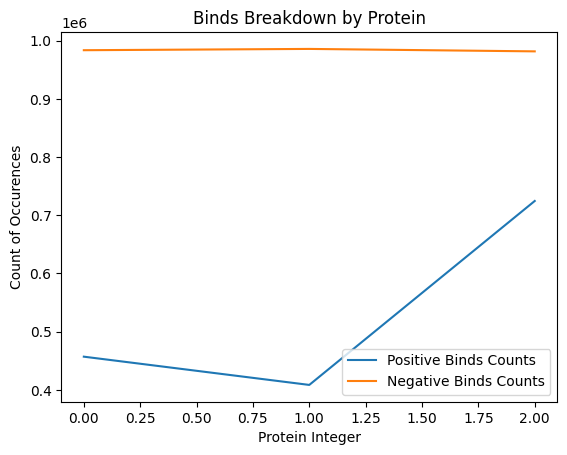

In [18]:
plt.plot(tot_prtn_ct["protein_int"], tot_prtn_ct["pos_prtn_ct"], label="Positive Binds Counts")
plt.plot(tot_prtn_ct["protein_int"], tot_prtn_ct["neg_prtn_ct"], label="Negative Binds Counts")

plt.xlabel("Protein Integer")
plt.ylabel("Count of Occurences")
plt.title("Binds Breakdown by Protein")

plt.legend(loc="lower right")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


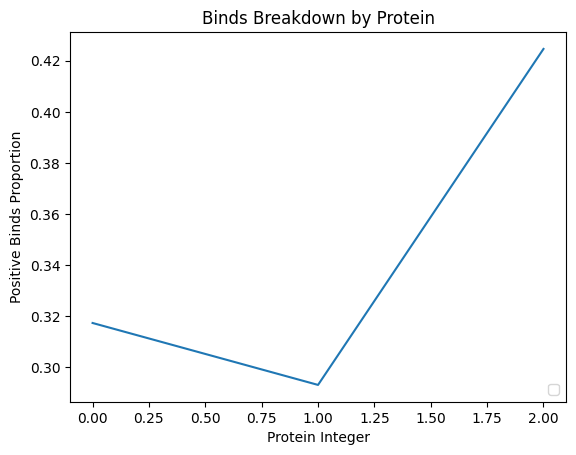

In [20]:
plt.plot(tot_prtn_ct["protein_int"], tot_prtn_ct["prtn_pct_pos"])

plt.xlabel("Protein Integer")
plt.ylabel("Positive Binds Proportion")
plt.title("Binds Breakdown by Protein")

plt.legend(loc="lower right")

BRD4, HSA, and sEH all have similar value counts for negative "binds" records in the silver layer. This would indicate that they're likely relatively evenly associated with negative "binds" results due to the downsampling technique being random. sEH has the highest proportion of its appearances being with a positive "binds" value at 0.42 in the silver layer downsampled data. This indicates the sEH protein has a relationship with "binds" that causes higher positive instances. BRD4 and HSA have lower and similar positive "binds" incidence rates in the silver layer. 

Keep in mind there are almost certainly interactions amongst the "protein_int" and "molecule_smiles" feature columns so while this analysis is useful to motivate keeping "protein_int" as a feature due to sEH's higher incidence of positive "binds" there is likely a much more complex relationship going on here that ML models can pick up on. 

### Molecule Smiles